# BERT-NLI

...

In [1]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
import time

npx.set_np()

batch_size, ctx = 512, d2l.try_all_gpus()
bert_train_iter, vocab = d2l.load_data_wiki(batch_size, 'wikitext-2')

bert = d2l.BERTModel(len(vocab), embed_size=128, hidden_size=256, num_heads=2,
                     num_layers=2, dropout=0.2)
bert.initialize(init.Xavier(), ctx=ctx)
nsp_loss = gluon.loss.SoftmaxCELoss()
mlm_loss = gluon.loss.SoftmaxCELoss()

d2l.train_bert(bert_train_iter, bert, nsp_loss, mlm_loss, len(vocab), ctx, 20, 3000)

Eval mlm_loss=14.701	nsp_loss=1.512	
Eval cost=7.9s


Eval mlm_loss=6.901	nsp_loss=0.698	
Eval cost=7.6s


Eval mlm_loss=4.599	nsp_loss=0.465	
Eval cost=7.6s


Eval mlm_loss=3.448	nsp_loss=0.348	
Eval cost=7.6s


Eval mlm_loss=2.757	nsp_loss=0.279	
Eval cost=7.6s


Eval mlm_loss=2.292	nsp_loss=0.233	
Eval cost=7.5s


Eval mlm_loss=1.949	nsp_loss=0.195	
Eval cost=7.5s


Eval mlm_loss=1.682	nsp_loss=0.164	
Eval cost=7.5s


Eval mlm_loss=1.473	nsp_loss=0.138	
Eval cost=7.6s


Eval mlm_loss=1.307	nsp_loss=0.118	
Eval cost=7.6s


Eval mlm_loss=1.171	nsp_loss=0.103	
Eval cost=7.6s


Eval mlm_loss=1.058	nsp_loss=0.089	
Eval cost=7.6s


Eval mlm_loss=0.963	nsp_loss=0.078	
Eval cost=7.6s


Eval mlm_loss=0.880	nsp_loss=0.068	
Eval cost=7.6s


Eval mlm_loss=0.808	nsp_loss=0.060	
Eval cost=7.6s


Eval mlm_loss=0.744	nsp_loss=0.054	
Eval cost=7.8s


Eval mlm_loss=0.689	nsp_loss=0.047	
Eval cost=7.7s


Eval mlm_loss=0.641	nsp_loss=0.042	
Eval cost=7.5s


Eval mlm_loss=0.599	nsp_loss=0.037	
Eval cost=7.6s


Eval mlm_loss=0.562	nsp_loss=0.033	
Eval cost=7.6s


Eval mlm_loss=0.528	nsp_loss=0.030	
Eval cost=7.6s


Eval mlm_loss=0.498	nsp_loss=0.027	
Eval cost=7.6s


Eval mlm_loss=0.471	nsp_loss=0.025	
Eval cost=7.6s


Eval mlm_loss=0.446	nsp_loss=0.022	
Eval cost=7.7s


Eval mlm_loss=0.424	nsp_loss=0.021	
Eval cost=7.6s


Eval mlm_loss=0.403	nsp_loss=0.018	
Eval cost=7.6s


...

In [2]:
class SNLIBERTDataset(gluon.data.Dataset):
    def __init__(self, dataset, vocab = None):
        self.num_steps = 50  # We fix the length of each sentence to 50.
        p_tokens = d2l.tokenize(dataset[0], token='word')
        h_tokens = d2l.tokenize(dataset[1], token='word')
        self.vocab = vocab
        
        self.tokens, self.segment_ids, self.valid_lengths = self.preprocess(p_tokens, h_tokens)
        self.labels = np.array(dataset[2])
        print('read ' + str(len(self.tokens)) + ' examples')
    def preprocess(self, p_tokens, h_tokens):
        def pad(data):
            return d2l.trim_pad(data, self.num_steps, 0)
        
        tokens, segment_ids, valid_lengths = [], [], []
        
        for i in range(len(p_tokens)):
            token, segment_id = d2l.get_tokens_and_segment(p_tokens[i][:self.num_steps], 
                                                           h_tokens[i][:self.num_steps])
            tokens.append(self.vocab[pad(token)])
            segment_ids.append(np.array(pad(segment_id)))
            valid_lengths.append(np.array(len(token)))
            
        return tokens, segment_ids, valid_lengths
    

    def __getitem__(self, idx):
        return (self.tokens[idx], self.segment_ids[idx], self.valid_lengths[idx]), self.labels[idx]

    def __len__(self):
        return len(self.tokens)

...

In [3]:
data_dir = d2l.download_extract('SNLI')
train_data = d2l.read_snli(data_dir, True)
test_data = d2l.read_snli(data_dir, False)
train_set = SNLIBERTDataset(train_data, vocab)
test_set = SNLIBERTDataset(test_data, vocab)

read 549367 examples


read 9824 examples


...

In [4]:
batch_size = 256
train_iter = gluon.data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = gluon.data.DataLoader(test_set, batch_size)

...

In [5]:
class BERTClassifier(nn.Block):
    def __init__(self, bert, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.classifier = gluon.nn.Sequential()
        self.classifier.add(gluon.nn.Dense(256, flatten=False, activation='relu'))
        self.classifier.add(gluon.nn.Dense(num_classes))

    def forward(self, X):
        inputs, segment_types, seq_len = X
        seq_encoding, _, _ = self.bert(inputs, segment_types, seq_len)
        return self.classifier(seq_encoding[:, 0, :])

...

In [6]:
net = BERTClassifier(bert, 3)
net.classifier.initialize(ctx=ctx)

...

loss 1.053, train acc 0.440, test acc 0.459
7061.4 examples/sec on [gpu(0), gpu(1)]


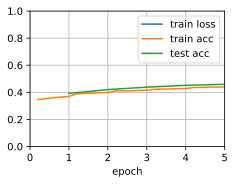

In [7]:
lr, num_epochs = 1e-5, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx, d2l.split_batch_multi_inputs)

...